# Data 
Original data comes from Kaggle Rossmann Store Sales https://www.kaggle.com/c/rossmann-store-sales/data

Original data has 3 files: train.csv, test.csv, store.csv

Data fields

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


# Import packages

In [34]:
import pandas as pd
import warnings
import seaborn as sns
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

warnings.simplefilter("ignore")
pd.options.display.max_columns = None

In [2]:
input_path = 'rossmann/'

In [3]:
# files in this folder
!ls {input_path}

googletrend.csv       store.csv             train.csv
sample_submission.csv store_states.csv      weather.csv
state_names.csv       test.csv


# Read data

In [4]:
# table_names = ['train' , 'test', 'store']
# tables = [pd.read_csv(f'{input_path }{fname}.csv', low_memory=False) for fname in table_names]

# df_train ,df_test, df_store = tables

In [42]:
df_train = pd.read_csv(input_path + 'train.csv', parse_dates=['Date'])

# Initial investigation 

In [6]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
df_train.shape

(1017209, 9)

# Profile report

In [8]:
profile = ProfileReport(df_train, title='Pandas Profiling Report')
profile.to_notebook_iframe()

The problems with training data are: 
- 17% sales are 0 
- 17% customers are 0
- a certain percent of stores are closed
- promo accounts for 38% of transactions
- school holiday seems to correlated with store closure
- features have high correlation with Sales are: customers, open, promo, day of week
- customers is the number of customers in the store, should not be taken as feature
- school holiday and store seems to have minimal impact on store sales
- Sunday seems to have very low sales
- no missing values - good

# Look at 0 sales

In [9]:
zero_sales = df_train.loc[df_train['Sales'] == 0]

In [10]:
zero_sales.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,172871.000000,172871.000000,172871.0,172871.000000,172871.000000,172871.000000,172871.00000
mean,558.470524,6.332948,0.0,0.000046,0.000312,0.064817,0.10572
std,322.776536,1.548315,0.0,0.014024,0.017671,0.246204,0.30748
min,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.00000
25%,279.000000,7.000000,0.0,0.000000,0.000000,0.000000,0.00000
50%,560.000000,7.000000,0.0,0.000000,0.000000,0.000000,0.00000
75%,839.000000,7.000000,0.0,0.000000,0.000000,0.000000,0.00000
max,1115.000000,7.000000,0.0,5.000000,1.000000,1.000000,1.00000


In [11]:
# The apparent finding is that when store is closed, sales will be 0
# so look at open store only
zero_sales_open = zero_sales.loc[zero_sales['Open'] == 1]

In [12]:
zero_sales_open.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,54.000000,54.000000,54.0,54.000000,54.0,54.000000,54.000000
mean,582.592593,3.703704,0.0,0.148148,1.0,0.388889,0.222222
std,340.093190,1.312202,0.0,0.786859,0.0,0.492076,0.419643
min,25.000000,1.000000,0.0,0.000000,1.0,0.000000,0.000000
25%,330.000000,3.000000,0.0,0.000000,1.0,0.000000,0.000000
50%,662.000000,4.000000,0.0,0.000000,1.0,0.000000,0.000000
75%,885.750000,4.000000,0.0,0.000000,1.0,1.000000,0.000000
max,1100.000000,6.000000,0.0,5.000000,1.0,1.000000,1.000000


In [13]:
zero_sales_open['StateHoliday'].value_counts()

0    34
0    20
Name: StateHoliday, dtype: int64

In [14]:
zero_sales_open.shape

(54, 9)

In [15]:
zero_sales_open.loc[zero_sales_open['Store']==28]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
346734,28,4,2014-09-04,0,0,1,1,0,0
347669,28,3,2014-09-03,0,0,1,1,0,1
348604,28,2,2014-09-02,0,0,1,1,0,1


54 store days have 0 sales even if store is open and no state holiday. 

Something might happen on those stores, we can safely exclude these from training data since they are so minor

# State Holiday

In [16]:
df_train['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [17]:
df_train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

Need to deal with numeric 0 and string 0, also need to do one hot encoding

<AxesSubplot:xlabel='StateHoliday', ylabel='Sales'>

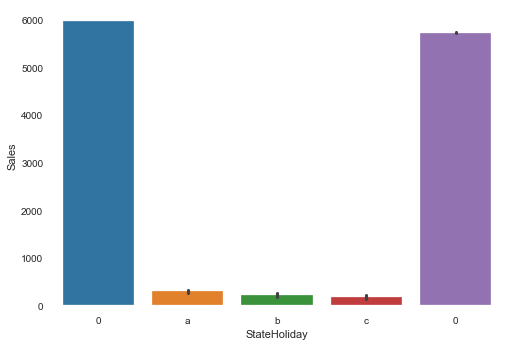

In [18]:
sns.barplot(df_train['StateHoliday'], df_train['Sales'])

public holiday has higher sales than other 2 holidays

# Store closure

Remove all closed store from training data. 

# School holiday

In [19]:
df_train['SchoolHoliday'].value_counts()

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

In [20]:
school_holiday = df_train[df_train['SchoolHoliday']==1]

In [21]:
school_holiday.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,181721.000000,181721.000000,181721.000000,181721.000000,181721.000000,181721.000000,181721.0
mean,558.871991,3.118698,6476.522207,704.412941,0.899494,0.451802,1.0
std,321.631983,1.516767,3709.677337,447.478907,0.300674,0.497673,0.0
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,281.000000,2.000000,4447.000000,480.000000,1.000000,0.000000,1.0
50%,559.000000,3.000000,6197.000000,654.000000,1.000000,0.000000,1.0
75%,838.000000,4.000000,8343.000000,881.000000,1.000000,1.000000,1.0
max,1115.000000,7.000000,38367.000000,5192.000000,1.000000,1.000000,1.0


In [22]:
school_holiday['Open'].value_counts()

1    163457
0     18264
Name: Open, dtype: int64

Most stores are closed on school holidays

# Promo

<AxesSubplot:xlabel='Promo', ylabel='Sales'>

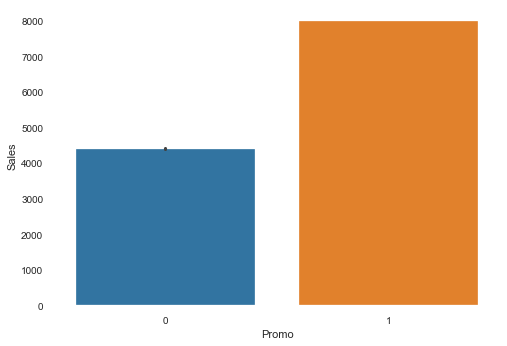

In [23]:
sns.barplot(df_train['Promo'], df_train['Sales'])

In [59]:
df_train['Promo'].sum()/len(df_train['Promo'])

0.3815145166824124

There are 38% promos in store, and sales are significant higher on promo days

# Dates

In [24]:
df_train['DayOfWeek'].value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

<AxesSubplot:xlabel='DayOfWeek', ylabel='Sales'>

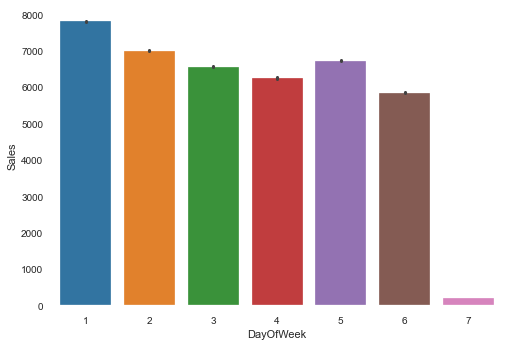

In [25]:
sns.barplot(df_train['DayOfWeek'], df_train['Sales'])

In [26]:
df_train['Date'].min()

Timestamp('2013-01-01 00:00:00')

In [27]:
df_train['Date'].max()

Timestamp('2015-07-31 00:00:00')

In [28]:
df_train['year'] = df_train['Date'].dt.year
df_train['month'] = df_train['Date'].dt.month
df_train['day'] = df_train['Date'].dt.day
df_train['quarter'] = df_train['Date'].dt.quarter
df_train['weekofyear'] = df_train['Date'].dt.weekofyear

<AxesSubplot:xlabel='year', ylabel='Sales'>

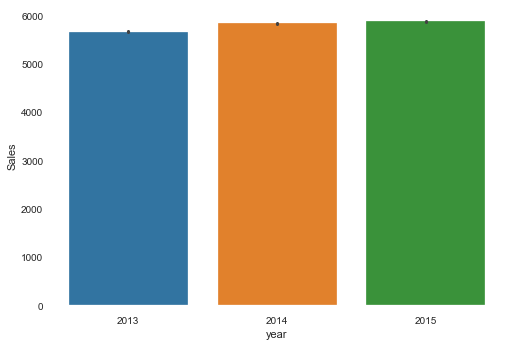

In [29]:
sns.barplot(df_train['year'], df_train['Sales'])

Seems to have very small yoy trend

<AxesSubplot:xlabel='month', ylabel='Sales'>

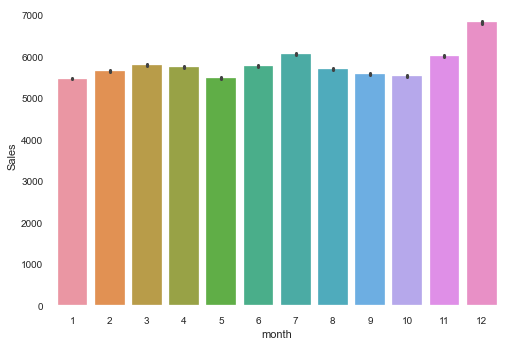

In [30]:
sns.barplot(df_train['month'], df_train['Sales'])

December has the highest sales

<AxesSubplot:xlabel='quarter', ylabel='Sales'>

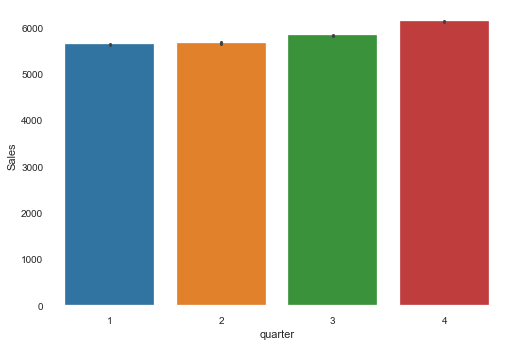

In [31]:
sns.barplot(df_train['quarter'], df_train['Sales'])

<AxesSubplot:xlabel='weekofyear', ylabel='Sales'>

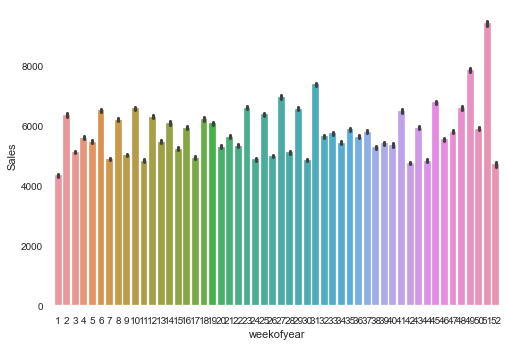

In [32]:
sns.barplot(df_train['weekofyear'], df_train['Sales'])

In [33]:
df_train.corr()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,year,month,day,quarter,weekofyear
Store,1.000000,-0.000008,0.005126,0.024325,-0.000047,0.000058,0.000641,0.000290,0.001467,0.000023,0.001491,0.001421
DayOfWeek,-0.000008,1.000000,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388,0.001937,-0.005362,0.005136,-0.008071,-0.004880
Sales,0.005126,-0.462125,1.000000,0.894711,0.678472,0.452345,0.085124,0.023519,0.048768,-0.011612,0.043984,0.052946
Customers,0.024325,-0.386445,0.894711,1.000000,0.616768,0.316169,0.071568,-0.001212,0.038179,-0.004473,0.036096,0.041404
Open,-0.000047,-0.528963,0.678472,0.616768,1.000000,0.295042,0.086171,-0.001009,-0.000681,0.033428,0.003561,0.004792
Promo,0.000058,-0.392925,0.452345,0.316169,0.295042,1.000000,0.067483,0.024300,-0.011747,-0.108325,-0.007293,0.000572
SchoolHoliday,0.000641,-0.205388,0.085124,0.071568,0.086171,0.067483,1.000000,-0.036535,0.103282,0.030538,0.148667,0.071052
year,0.000290,0.001937,0.023519,-0.001212,-0.001009,0.024300,-0.036535,1.000000,-0.269382,-0.002485,-0.260642,-0.256619
month,0.001467,-0.005362,0.048768,0.038179,-0.000681,-0.011747,0.103282,-0.269382,1.000000,0.012442,0.968723,0.967034
day,0.000023,0.005136,-0.011612,-0.004473,0.033428,-0.108325,0.030538,-0.002485,0.012442,1.000000,0.014186,0.069624


Observations:
- weekofyear has very high correlation with month, quarter
- quarter has very high correlation with month

# Some trends

In [38]:
df_train.groupby(['Store'])['Sales'].sum().sort_values()

Store
307      2114322
543      2179287
198      2268273
208      2302052
263      2306075
          ...   
251     14896870
1114    16202585
562     16927322
817     17057867
262     19516842
Name: Sales, Length: 1115, dtype: int64

In [45]:
df_train['Date'] = pd.to_datetime(df_train['Date'], infer_datetime_format=True)

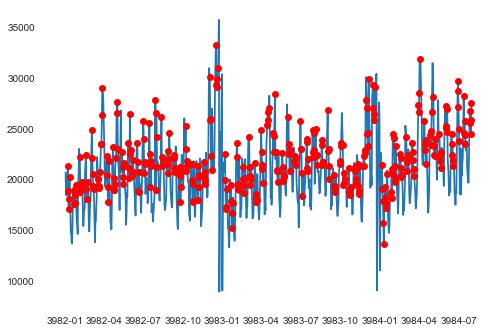

In [70]:
df_store_example = df_train.loc[(df_train['Store']==1114) & (df_train['Sales']>0)].sort_values('Date')
promo_store_example = df_store_example.loc[df_store_example['Promo']==1]
plt.plot(df_store_example['Date'], df_store_example['Sales'])
plt.plot(promo_store_example['Date'], promo_store_example['Sales'], 'ro')

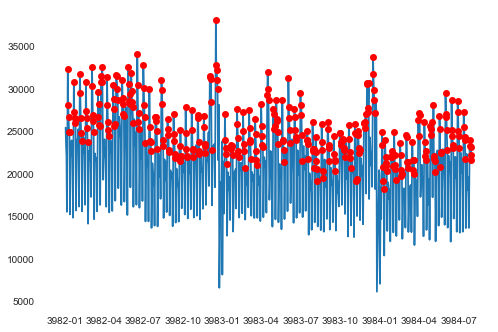

In [71]:
df_store_example = df_train.loc[(df_train['Store']==817) & (df_train['Sales']>0)].sort_values('Date')
promo_store_example = df_store_example.loc[df_store_example['Promo']==1]
plt.plot(df_store_example['Date'], df_store_example['Sales'])
plt.plot(promo_store_example['Date'], promo_store_example['Sales'], 'ro')

clearly promo drives sales in this store

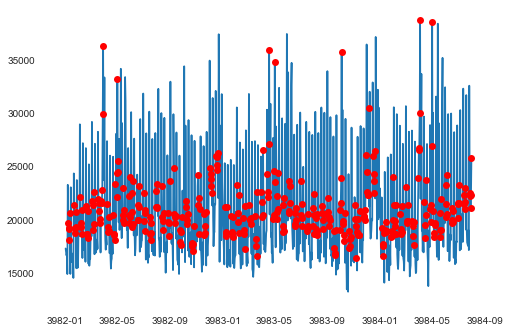

In [69]:
df_store_example = df_train.loc[df_train['Store']==262].sort_values('Date')
promo_store_example = df_store_example.loc[df_store_example['Promo']==1]
plt.plot(df_store_example['Date'], df_store_example['Sales'])
plt.plot(promo_store_example['Date'], promo_store_example['Sales'], 'ro')

But not so much significant in this store

In [50]:
df_store_262.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 1016356 to 261
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store          942 non-null    int64         
 1   DayOfWeek      942 non-null    int64         
 2   Date           942 non-null    datetime64[ns]
 3   Sales          942 non-null    int64         
 4   Customers      942 non-null    int64         
 5   Open           942 non-null    int64         
 6   Promo          942 non-null    int64         
 7   StateHoliday   942 non-null    object        
 8   SchoolHoliday  942 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 73.6+ KB


In [57]:
df_store_262['Date'].iloc[0]

Timestamp('2013-01-01 00:00:00')

# Sum up

Things need to do in feature engineering
- exclude 0 sales
- exclude store closure
- state holiday: one hot encoding
- date: add year, month, weekofyear, quarter, delete date